In [183]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind, bartlett,levene, f_oneway, shapiro, probplot

import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import researchpy as rp
 
import umap
from pingouin import welch_anova

# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

In [3]:
df = pd.read_csv('data/raw/master.csv')

In [4]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Данные выглядят хорошо, но видим, что есть пропущенные значения в фиче HDI for year

In [6]:
df.loc[:, df.columns != 'HDI for year'].isnull().values.any()

False

Кроме этой колонки, других пропущенных значений нет. Думаю ее, для данного анализа, можно отбросить. 

In [7]:
df = df.loc[:, df.columns != 'HDI for year']

In [8]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,"2,156,624,900",796,Boomers


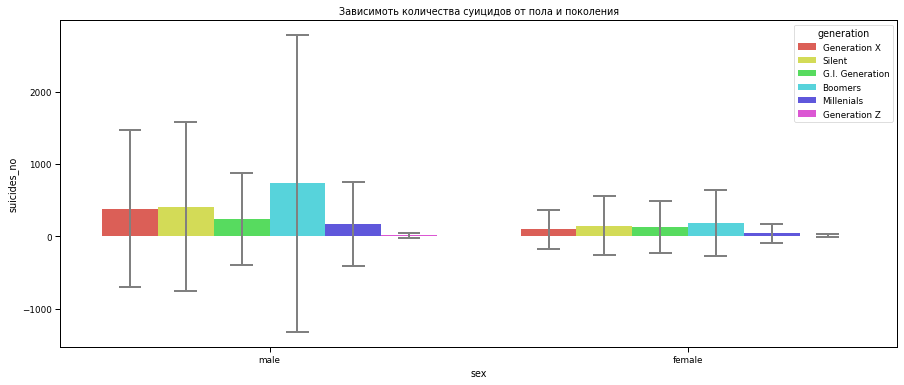

In [186]:
fig = plt.figure(figsize =(15, 6)) 
plt.title('Зависимоть количества суицидов от пола и поколения')
sns.barplot(x = 'sex', y = 'suicides_no', hue = 'generation', data = df,
            palette = 'hls',
            order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'  
            )

plt.show()

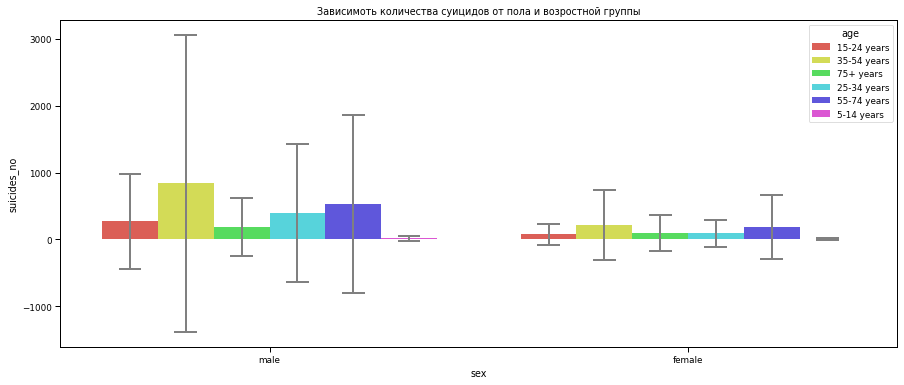

In [187]:
fig = plt.figure(figsize =(15, 6))
plt.title('Зависимоть количества суицидов от пола и возростной группы')
sns.barplot(x = 'sex', y = 'suicides_no', hue = 'age', data = df,
            palette = 'hls',
            order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )
plt.show()


### Комментарий к графикам 

Мы можем предположить из граффиков, что мужчины больше подвержены суицидам, особенны мужчины в возрасте от 35 до 54 сел поколения Бумеров

In [20]:
print(f'')
print(f'Среднее количество самоубийств по полу и поколению ')
print(f'')
print(df.groupby(['sex', 'generation']).mean()['suicides_no'])
print(f'')
print(f'Стандартное отклонение количества самоубийств по полу и поколению ')
print(f'')
print(df.groupby(['sex', 'generation']).std()['suicides_no'])


Среднее количество самоубийств по полу и поколению 

sex     generation     
female  Boomers            184.756713
        G.I. Generation    128.755831
        Generation X        96.703808
        Generation Z         8.355102
        Millenials          45.728953
        Silent             148.425204
male    Boomers            730.873747
        G.I. Generation    242.970845
        Generation X       381.699438
        Generation Z        13.285714
        Millenials         167.638261
        Silent             411.519485
Name: suicides_no, dtype: float64

Стандартное отклонение количества самоубийств по полу и поколению 

sex     generation     
female  Boomers             457.381226
        G.I. Generation     357.423903
        Generation X        271.906464
        Generation Z         18.266134
        Millenials          131.258175
        Silent              405.616059
male    Boomers            2047.742174
        G.I. Generation     637.060934
        Generation X       

### Комметарий 

По этим оценкам можно сказать, что наименьше все подвержены суицидам женщины поколения Z со средним  8.35 и std 18.26

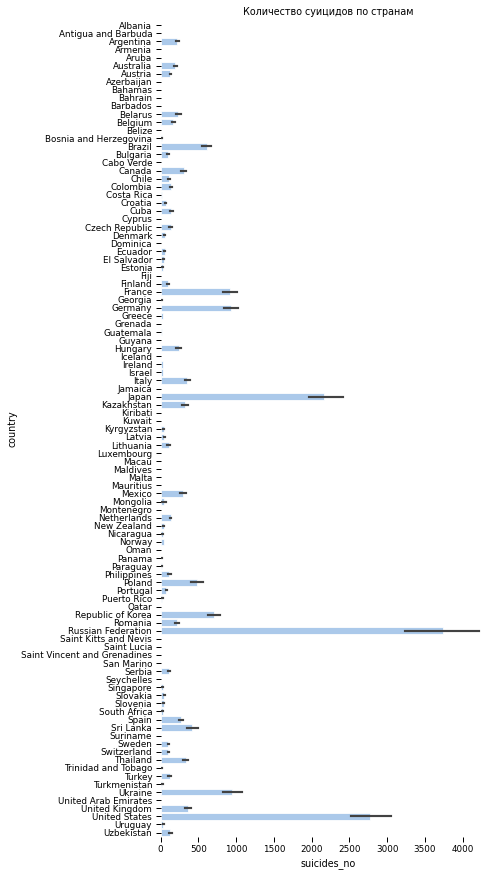

In [188]:
sns.set_context('paper')


f, ax = plt.subplots(figsize = (6,15))
plt.title('Количество суицидов по странам')
sns.set_color_codes('pastel')
sns.barplot(x = 'suicides_no', y = 'country', data = df,
            label = 'Total', color = 'b', edgecolor = 'w')

sns.despine(left = True, bottom = True)
plt.show()

На этом графике видно, что самые подверженные суицидам страны это Россия (на 1 месте), США (на 2) и Япония(на 3)

# 1.2 

Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

В этом задании, для проверки гипотез, я выбрал еритерий Велча для проверки равенства средних при разной дисперсии выборки

In [51]:
df_m = df['suicides_no'][df['sex'] == 'male']
df_f = df['suicides_no'][df['sex'] == 'female']

In [56]:
df_f.count()

13910

In [52]:
# Welch's t-test
des, res = rp.ttest(df_m, df_f,
                            equal_variances= False)

des

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,suicides_no,13910.0,373.034508,1217.448508,10.322551,352.800919,393.268096
1,suicides_no,13910.0,112.114306,333.491224,2.827619,106.571793,117.656819
2,combined,27820.0,242.574407,902.047917,5.408179,231.974110,253.174704


In [53]:
res

,Welch's t-test,results
0,Difference (suicides_no - suicides_no) =,260.9202
1,Degrees of freedom =,15984.6549
2,t =,24.3786
3,Two side test p value =,0.0000
4,Difference < 0 p value =,1.0000
5,Difference > 0 p value =,0.0000
6,Cohen's d =,0.2923
7,Hedge's g =,0.2923
8,Glass's delta =,0.2143
9,r =,0.1893


Для уточнения p-value

In [59]:
ttest_ind(df_m, df_f, equal_var = False)

Ttest_indResult(statistic=24.378626630539273, pvalue=6.4421074798191e-129)

Так как абсолютное значение статистики теста больше чем критическое значение two-tail, средние двух выборок значительно отличаются
Очень маленькое p-value подверждает это, и мы имеет основания отклонить нулевую гипотезу о равестве средних

Я думаю, что мы можем сказать с большой долей уверености, что есть статистическая разница между тем, как часто совершают самоубийства мужчины и женщины в среднем 

# Часть 2 

For 2016: divide countries into 3-4 groups according to the values of the gdp_per_capita feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

Отберем нужные нам данные по году

In [63]:
df_2016 = df[df['year'] == 2016]

In [64]:
df_2016.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation
1248,Armenia,2016,male,75+ years,12,61956,19.37,Armenia2016,"10,546,135,160",3788,Silent
1249,Armenia,2016,male,55-74 years,16,237813,6.73,Armenia2016,"10,546,135,160",3788,Boomers
1250,Armenia,2016,male,35-54 years,16,350633,4.56,Armenia2016,"10,546,135,160",3788,Generation X
1251,Armenia,2016,male,15-24 years,5,202220,2.47,Armenia2016,"10,546,135,160",3788,Millenials
1252,Armenia,2016,female,75+ years,2,102414,1.95,Armenia2016,"10,546,135,160",3788,Silent


Строим график, чтобы посмотреть, как можно разбить страны по доходу 

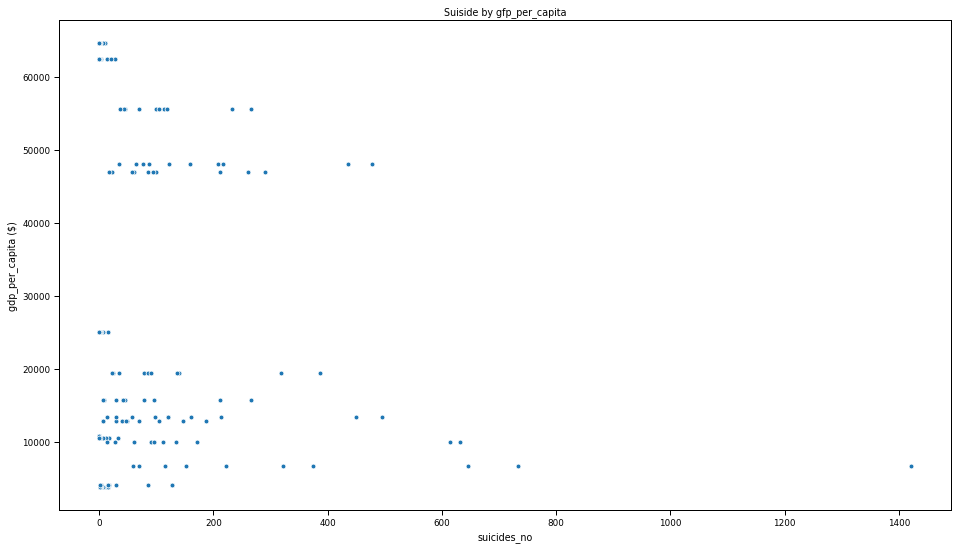

In [87]:
plt.figure(figsize = (16,9))
ax = sns.scatterplot(x=df_2016['suicides_no'], y=df_2016['gdp_per_capita ($)'])
plt.title("Suiside by gfp_per_capita")
plt.show()

Опять видим большой разрыв между 30 000 и 40 000, не знаю с чем связан

Так же бросается в глаза выбрас на 1400 самоубийств. Думаю его стоит обработать

In [108]:
df_2016[df_2016['suicides_no'] > 1400]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation
25303,Thailand,2016,male,35-54 years,1421,10084647,14.09,Thailand2016,"411,755,164,833",6713,Generation X


Видим, что в этом году случилось что то экстримальное с поколением Х в Тайланде. Думаю убрать это наблюдение пока что из выборки

In [117]:
df_2016_n = df_2016.drop(df_2016[df_2016['suicides_no'] > 1400].index)   

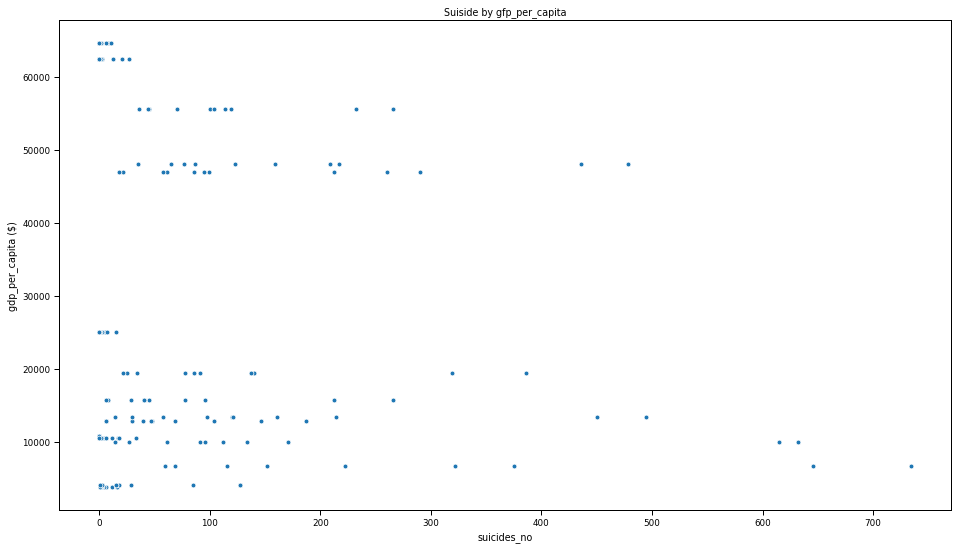

In [118]:
plt.figure(figsize = (16,9))
ax = sns.scatterplot(x=df_2016_n['suicides_no'], y=df_2016_n['gdp_per_capita ($)'])
plt.title("Suiside by gfp_per_capita")
plt.show()

Разбиваем данные на 4 группы

In [137]:
df_2016_n['gdp_cat'] = pd.cut( df_2016_n['gdp_per_capita ($)'], bins = [0,11500,30000, 50000, 70000], right=False, labels=["Small","Medium","Large", "XL"] )

In [143]:
df_2016_n.reset_index()

,index,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation,gdp_cat
0,1248,Armenia,2016,male,75+ years,12,61956,19.37,Armenia2016,"10,546,135,160",3788,Silent,Small
1,1249,Armenia,2016,male,55-74 years,16,237813,6.73,Armenia2016,"10,546,135,160",3788,Boomers,Small
2,1250,Armenia,2016,male,35-54 years,16,350633,4.56,Armenia2016,"10,546,135,160",3788,Generation X,Small
3,1251,Armenia,2016,male,15-24 years,5,202220,2.47,Armenia2016,"10,546,135,160",3788,Millenials,Small
4,1252,Armenia,2016,female,75+ years,2,102414,1.95,Armenia2016,"10,546,135,160",3788,Silent,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,25307,Thailand,2016,female,75+ years,69,1589015,4.34,Thailand2016,"411,755,164,833",6713,Silent,Small
155,25308,Thailand,2016,female,55-74 years,222,6049756,3.67,Thailand2016,"411,755,164,833",6713,Boomers,Small
156,25309,Thailand,2016,female,35-54 years,375,10629684,3.53,Thailand2016,"411,755,164,833",6713,Generation X,Small
157,25310,Thailand,2016,female,25-34 years,116,4702656,2.47,Thailand2016,"411,755,164,833",6713,Millenials,Small


Я хочу использовать ANOVA для выявления разницы, но нужно проверить вначале, что дисперсия в группах одинаковая 

In [158]:
bartlett(df_2016_n['suicides/100k pop'][df_2016_n['gdp_cat'] == 'Small'],
      df_2016_n['suicides/100k pop'][df_2016_n['gdp_cat'] == 'Medium'],
      df_2016_n['suicides/100k pop'][df_2016_n['gdp_cat'] == 'Large'],
      df_2016_n['suicides/100k pop'][df_2016_n['gdp_cat'] == 'XL'])

BartlettResult(statistic=47.231441183003454, pvalue=3.1031149910693605e-10)

Как мы видим по Тесту Барлет, мы не имеет оснований отвергнуть его нулевую гипотезу о том, что все данные взяты из одной выборки с одинаковой дисперсии. По этому мы можем сделать тест ANOVA

In [159]:
rp.summary_cont(df_2016_n['suicides/100k pop'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,suicides/100k pop,159.0,13.417,17.136,1.359,10.7329,16.1011


In [160]:
rp.summary_cont(df_2016_n['suicides/100k pop'].groupby(df_2016_n['gdp_cat']))

,N,Mean,SD,SE,95% Conf.,Interval
gdp_cat,,,,,,
Small,59,8.5392,10.4251,1.3572,5.8223,11.2560
Medium,50,20.5106,24.1853,3.4203,13.6372,27.3840
Large,20,15.5310,14.5541,3.2544,8.7195,22.3425
XL,30,9.7780,10.1696,1.8567,5.9806,13.5754


Проведем тест ANOVA

In [170]:
df_2016_n.rename(columns = {'suicides/100k_pop':'suicides100k_pop'}, inplace = True) 

In [172]:
model = ols('suicides100k_pop ~ C(gdp_cat)', data=df_2016_n).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(gdp_cat),4406.417951,3.0,5.422013,0.001424
Residual,41989.003600,155.0,NaN,NaN


По результатам теста мы можем предположить, что существует существенная разница количества смертей от суицида, от колчиства gdp_per_capita ($). Но нам нужно провести еще дополнительный анализ.

In [173]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(gdp_cat),4406.417951,3.0,1468.805984,5.422013,0.001424,0.094975,0.077009
Residual,41989.003600,155.0,270.896797,NaN,NaN,NaN,NaN


### Независимость

Не могу сказать, каким образом собиралась это выборка, но предположу, что условия независимости здесь выполняются

### Нормальность

Нужно проверить остатки на нормальность. Для этого воспользуемся тестом Шапиро-Вилка. 

In [175]:
shapiro(model.resid)

ShapiroResult(statistic=0.7902101278305054, pvalue=7.972616978494523e-14)

Нулевая гипотеза состоит в том, что данные взяты из нормального распределения

По результат теста видим, что у нас нет оснований отвергать нулевую гипотезу 

Убедимся в этом, построив график 

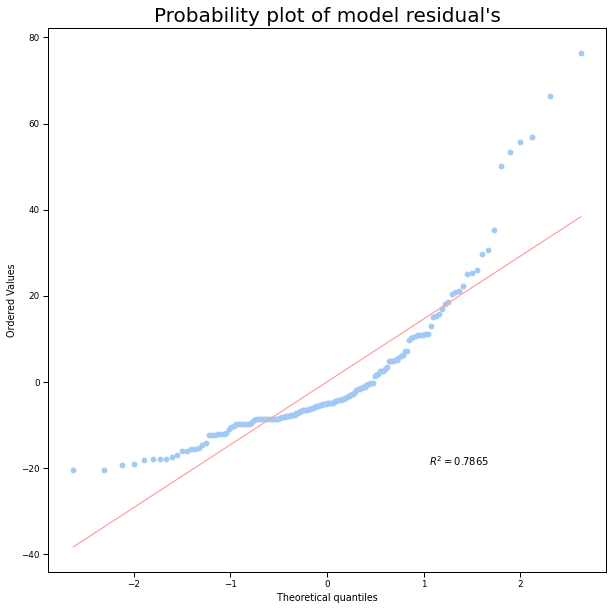

In [180]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

Не смотря на то, что тест показал нормальное распределение остатков, по графику видно, что это не так 

$R^2$ взяты из таблицы для N=155 примерно равен  0.9909

расчитанный $R^2$ не дотягивает до этого значения

Мы можем придти к выводу, что лучше использовать непараметрически тесты ANOVA такие как Welch`s ANOVA или Kruskal-Wallis ANOVA.

## Welch`s ANOVA 

In [185]:
aov = welch_anova(dv='suicides100k_pop', between='gdp_cat', data=df_2016_n)
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,gdp_cat,3,61.232054,4.303389,0.00807,0.094975


По результатам теста мы можем предположить, что существует существенная разница количества смертей от суицида, от колчиства gdp_per_capita ($). Но нам нужно провести еще дополнительный анализ.

Но для того, чтобы это подтвердить, нам нужно проверить, соблюдены ли все условия теста. 